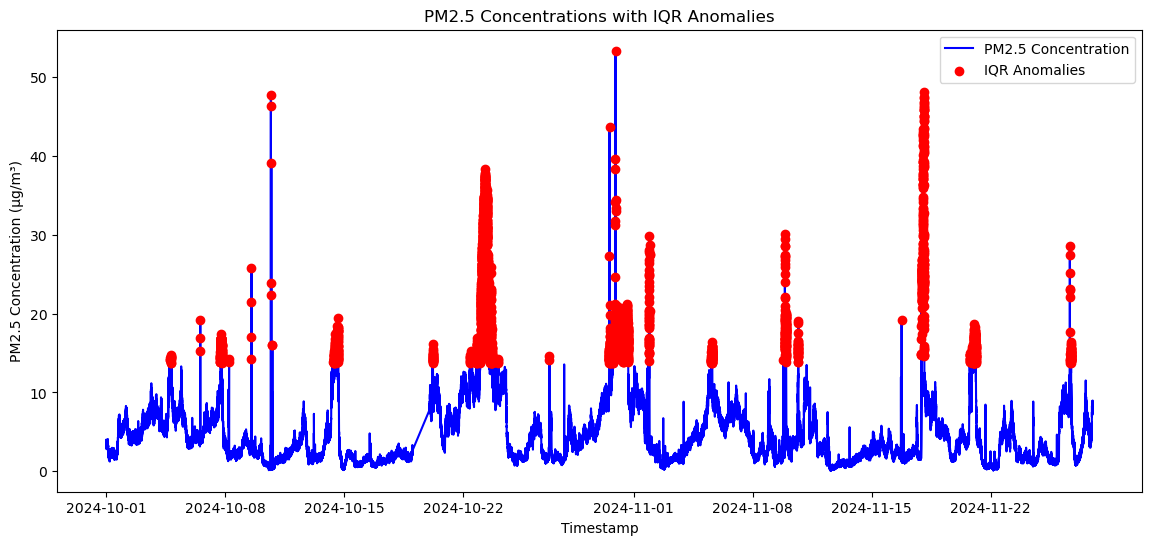

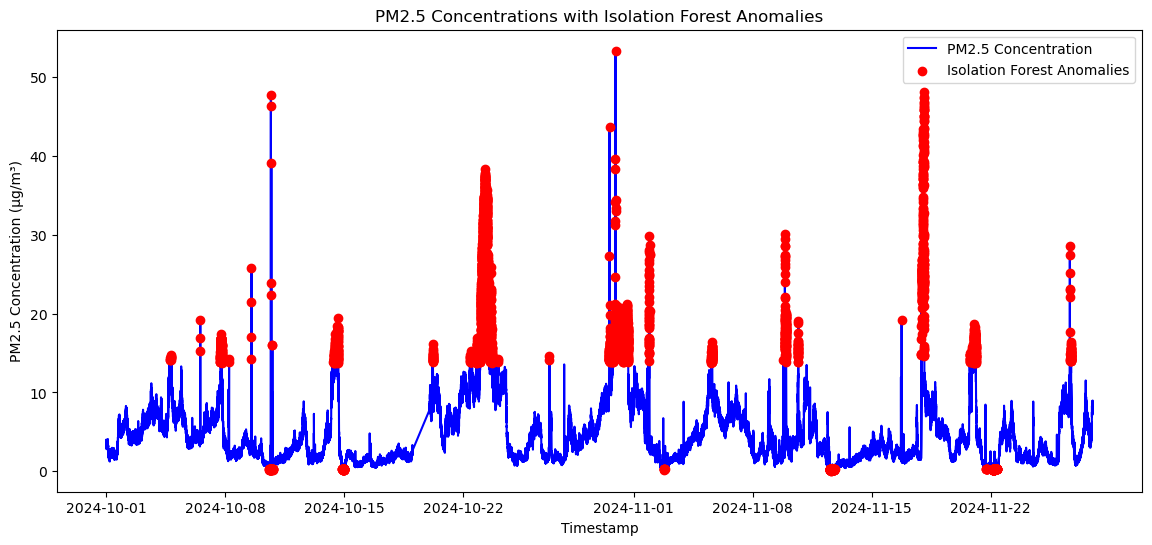

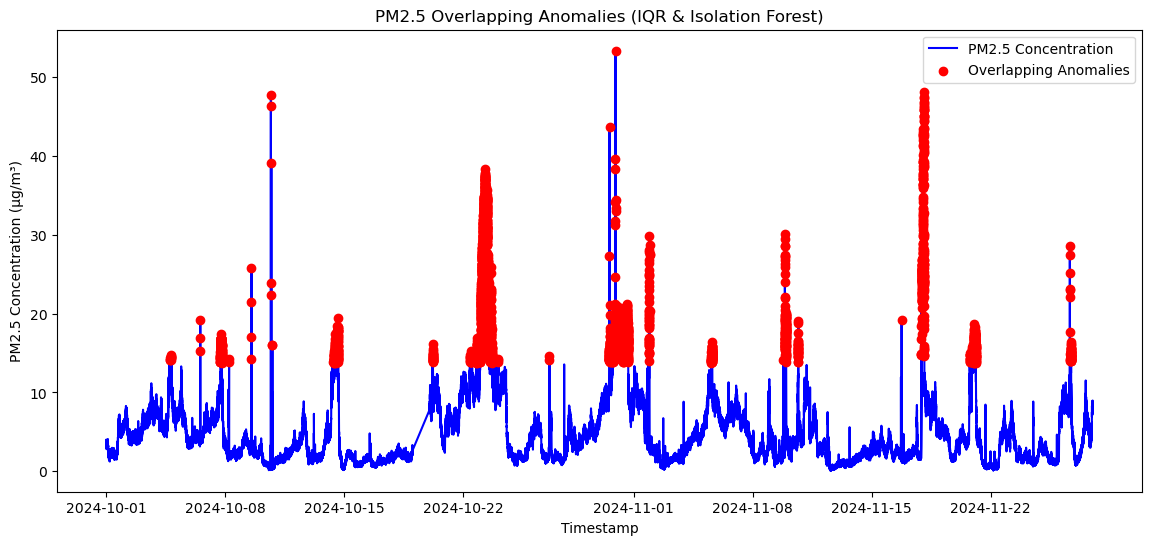

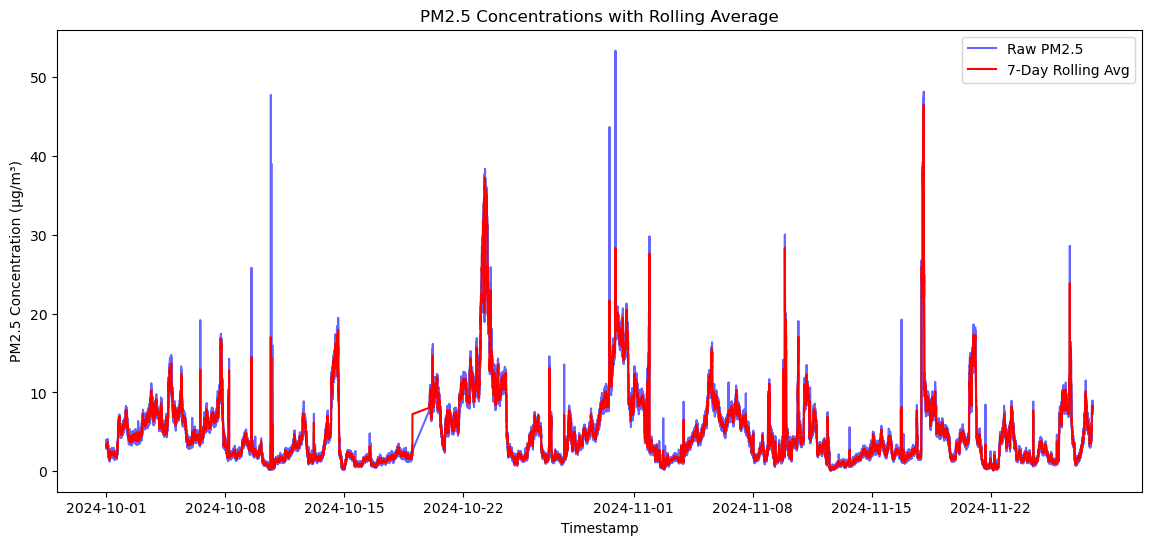

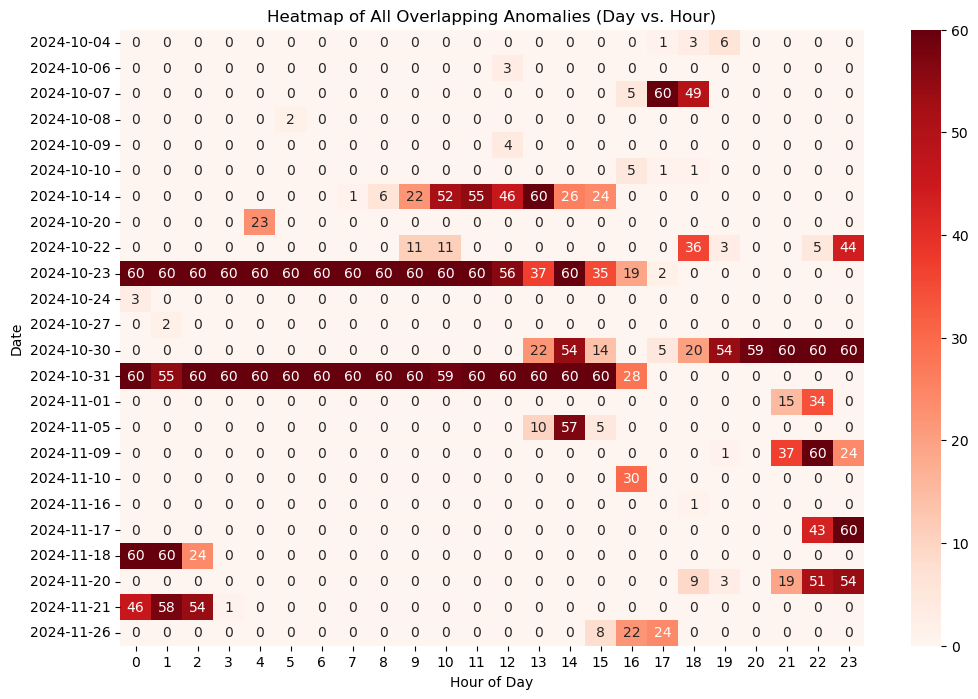

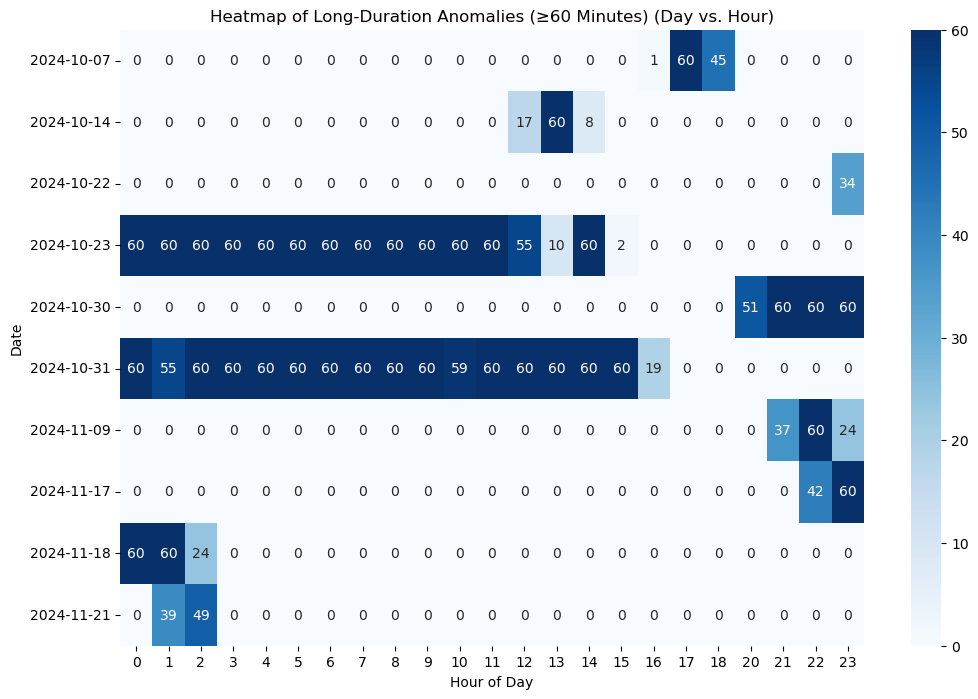

In [22]:
import pandas as pd  # For data manipulation and analysis
import matplotlib.pyplot as plt  # For creating visualizations
from sklearn.ensemble import IsolationForest  # For anomaly detection using Isolation Forest
import seaborn as sns  # For creating heatmaps and advanced visualizations

# Load the dataset
file_path = 'MOD-00068-146f1681c6f342799117874b40bbb3d3.csv'  # Path to your dataset
data = pd.read_csv(file_path)  # Read the CSV file into a Pandas DataFrame

# Convert the 'timestamp' column to datetime format for proper time-based operations
data['timestamp'] = pd.to_datetime(data['timestamp'])

# Filter the data to include only records from October 1 onward
data = data[data['timestamp'] >= '2024-10-01']

# Remove all records for October 19, as they are excluded from the analysis
data = data[~(data['timestamp'].dt.date == pd.Timestamp('2024-10-19').date())]

# Focus on PM2.5 concentration data and drop rows with missing values
pm25_data = data[['timestamp', 'pm25']].dropna()

### IQR-Based Anomaly Detection ############################################################################
def detect_anomalies_iqr(column):
    """
    Detect anomalies using the Interquartile Range (IQR) method.
    Parameters:
    - column: A Pandas Series containing the data to analyze.
    Returns:
    - lower_bound: Lower threshold for anomalies.
    - upper_bound: Upper threshold for anomalies.
    """
    Q1 = column.quantile(0.25)  # Calculate the 25th percentile (Q1)
    Q3 = column.quantile(0.75)  # Calculate the 75th percentile (Q3)
    IQR = Q3 - Q1  # Compute the Interquartile Range (IQR)
    lower_bound = Q1 - 1.5 * IQR  # Define the lower threshold for anomalies
    upper_bound = Q3 + 1.5 * IQR  # Define the upper threshold for anomalies
    return lower_bound, upper_bound

# Calculate thresholds for anomalies using IQR
pm25_lower, pm25_upper = detect_anomalies_iqr(pm25_data['pm25'])

# Mark anomalies based on IQR thresholds
pm25_data['iqr_anomaly'] = (pm25_data['pm25'] < pm25_lower) | (pm25_data['pm25'] > pm25_upper)

# Plot PM2.5 concentrations with IQR anomalies highlighted
plt.figure(figsize=(14, 6))  # Set the figure size
plt.plot(pm25_data['timestamp'], pm25_data['pm25'], label='PM2.5 Concentration', color='blue')  # Plot PM2.5 values
plt.scatter(
    pm25_data.loc[pm25_data['iqr_anomaly'], 'timestamp'],  # Anomaly timestamps
    pm25_data.loc[pm25_data['iqr_anomaly'], 'pm25'],  # Anomaly PM2.5 values
    color='red', label='IQR Anomalies', zorder=5  # Highlight anomalies in red
)
plt.title('PM2.5 Concentrations with IQR Anomalies')  # Add a title
plt.xlabel('Timestamp')  # Label the x-axis
plt.ylabel('PM2.5 Concentration (µg/m³)')  # Label the y-axis
plt.legend()  # Add a legend
plt.savefig('iqr_anomalies.png')  # Save the plot as a PNG file
plt.show()  # Display the plot

### Isolation Forest Anomaly Detection ####################################
# Initialize and train an Isolation Forest model with 5% contamination - the proportion of data points expected to be anomalies.
isolation_forest = IsolationForest(contamination=0.05, random_state=42) # randome state parameter controls the randomness of the algorithm, ensuring reproducibility of results. 
pm25_data['if_anomaly_score'] = isolation_forest.fit_predict(pm25_data[['pm25']])  # Fit the model and predict scores
pm25_data['if_anomaly'] = pm25_data['if_anomaly_score'] == -1  # Mark anomalies where the score is -1

# Plot PM2.5 concentrations with Isolation Forest anomalies highlighted
plt.figure(figsize=(14, 6))  # Set the figure size
plt.plot(pm25_data['timestamp'], pm25_data['pm25'], label='PM2.5 Concentration', color='blue')  # Plot PM2.5 values
plt.scatter(
    pm25_data.loc[pm25_data['if_anomaly'], 'timestamp'],  # Anomaly timestamps
    pm25_data.loc[pm25_data['if_anomaly'], 'pm25'],  # Anomaly PM2.5 values
    color='red', label='Isolation Forest Anomalies', zorder=5  # Highlight anomalies in red
)
plt.title('PM2.5 Concentrations with Isolation Forest Anomalies')  # Add a title
plt.xlabel('Timestamp')  # Label the x-axis
plt.ylabel('PM2.5 Concentration (µg/m³)')  # Label the y-axis
plt.legend()  # Add a legend
plt.savefig('if_anomalies.png')  # Save the plot as a PNG file
plt.show()  # Display the plot

### Overlapping Anomalies ###############################################################
# Mark anomalies detected by both methods (IQR and Isolation Forest)
pm25_data['overlap'] = pm25_data['iqr_anomaly'] & pm25_data['if_anomaly']

# Plot PM2.5 concentrations with overlapping anomalies highlighted
plt.figure(figsize=(14, 6))  # Set the figure size
plt.plot(pm25_data['timestamp'], pm25_data['pm25'], label='PM2.5 Concentration', color='blue')  # Plot PM2.5 values
plt.scatter(
    pm25_data.loc[pm25_data['overlap'], 'timestamp'],  # Overlap anomaly timestamps
    pm25_data.loc[pm25_data['overlap'], 'pm25'],  # Overlap anomaly PM2.5 values
    color='red', label='Overlapping Anomalies', zorder=5  # Highlight overlapping anomalies in red
)
plt.title('PM2.5 Overlapping Anomalies (IQR & Isolation Forest)')  # Add a title
plt.xlabel('Timestamp')  # Label the x-axis
plt.ylabel('PM2.5 Concentration (µg/m³)')  # Label the y-axis
plt.legend()  # Add a legend
plt.savefig('overlap_anomalies.png')  # Save the plot as a PNG file
plt.show()  # Display the plot

### Rolling Average of PM2.5 Concentrations ###
# Calculate a 7-day rolling average for PM2.5 concentrations
pm25_data['rolling_avg'] = pm25_data['pm25'].rolling(window=7).mean()

# Plot PM2.5 concentrations with the rolling average
plt.figure(figsize=(14, 6))
plt.plot(pm25_data['timestamp'], pm25_data['pm25'], label='Raw PM2.5', color='blue', alpha=0.6)  # Plot raw PM2.5
plt.plot(pm25_data['timestamp'], pm25_data['rolling_avg'], label='7-Day Rolling Avg', color='red')  # Plot rolling avg
plt.title('PM2.5 Concentrations with Rolling Average')  # Add a title
plt.xlabel('Timestamp')  # Label x-axis
plt.ylabel('PM2.5 Concentration (µg/m³)')  # Label y-axis
plt.legend()  # Add a legend
plt.savefig('rolling_average_pm25.png')  # Save the plot
plt.show()  # Display the plot

### Filter and Heatmap of Long-Duration Anomalies ###
# Group anomalies into events and calculate duration
pm25_data['event_group'] = (pm25_data['overlap'] != pm25_data['overlap'].shift()).cumsum()
anomaly_durations = pm25_data[pm25_data['overlap']].groupby('event_group').agg(
    start_time=('timestamp', 'min'),  # Start time of the event
    end_time=('timestamp', 'max'),    # End time of the event
    duration=('timestamp', lambda x: (x.max() - x.min()).seconds / 60)  # Duration in minutes
).reset_index()

# Filter out anomalies with durations less than 60 minutes
long_duration_anomalies = anomaly_durations[anomaly_durations['duration'] >= 60]

# Retain only long-duration anomalies in the main dataset
valid_event_groups = long_duration_anomalies['event_group'].unique()
pm25_data['long_duration_overlap'] = pm25_data['event_group'].isin(valid_event_groups)

# Create a pivot table for long-duration anomalies
heatmap_data_long = pm25_data[pm25_data['long_duration_overlap']].pivot_table(
    index=pm25_data['timestamp'].dt.date,  # Rows represent dates
    columns=pm25_data['timestamp'].dt.hour,  # Columns represent hours
    values='pm25',
    aggfunc='count',
    fill_value=0
)
pm25_data['hour'] = pm25_data['timestamp'].dt.hour  # Extract hour
pm25_data['day'] = pm25_data['timestamp'].dt.date  # Extract date

# Create a pivot table for all overlapping anomalies
heatmap_data_all = pm25_data[pm25_data['overlap']].pivot_table(
    index='day',  # Rows represent dates
    columns='hour',  # Columns represent hours
    values='pm25',  # Count anomalies
    aggfunc='count',  # Aggregate using count
    fill_value=0  # Replace NaN with 0
)

# Plot the heatmap for all overlapping anomalies
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data_all, cmap='Reds', annot=True, fmt='d', cbar=True)  # Create the heatmap
plt.title('Heatmap of All Overlapping Anomalies (Day vs. Hour)')  # Add a title
plt.xlabel('Hour of Day')  # Label x-axis
plt.ylabel('Date')  # Label y-axis
plt.savefig('heatmap_all_overlapping_anomalies.png')  # Save the heatmap
plt.show()  # Display the heatmap

### Heatmap of Long-Duration Anomalies (≥60 Minutes) ###
# Group anomalies into events and calculate duration
pm25_data['event_group'] = (pm25_data['overlap'] != pm25_data['overlap'].shift()).cumsum()
anomaly_durations = pm25_data[pm25_data['overlap']].groupby('event_group').agg(
    start_time=('timestamp', 'min'),  # Start time of the event
    end_time=('timestamp', 'max'),    # End time of the event
    duration=('timestamp', lambda x: (x.max() - x.min()).seconds / 60)  # Duration in minutes
).reset_index()

# Filter out anomalies with durations less than 60 minutes
long_duration_anomalies = anomaly_durations[anomaly_durations['duration'] >= 60]

# Retain only long-duration anomalies in the main dataset
valid_event_groups = long_duration_anomalies['event_group'].unique()
pm25_data['long_duration_overlap'] = pm25_data['event_group'].isin(valid_event_groups)

# Create a pivot table for long-duration anomalies
heatmap_data_long = pm25_data[pm25_data['long_duration_overlap']].pivot_table(
    index='day',  # Rows represent dates
    columns='hour',  # Columns represent hours
    values='pm25',  # Count anomalies
    aggfunc='count',  # Aggregate using count
    fill_value=0  # Replace NaN with 0
)

# Plot the heatmap for long-duration anomalies
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data_long, cmap='Blues', annot=True, fmt='d', cbar=True)  # Create the heatmap
plt.title('Heatmap of Long-Duration Anomalies (≥60 Minutes) (Day vs. Hour)')  # Add a title
plt.xlabel('Hour of Day')  # Label x-axis
plt.ylabel('Date')  # Label y-axis
plt.savefig('heatmap_long_duration_anomalies.png')  # Save the heatmap
plt.show()  # Display the heatmap

Classification Report (Testing Set):
              precision    recall  f1-score   support

       False       1.00      1.00      1.00      7821
        True       0.91      0.98      0.95       381

    accuracy                           0.99      8202
   macro avg       0.96      0.99      0.97      8202
weighted avg       1.00      0.99      0.99      8202



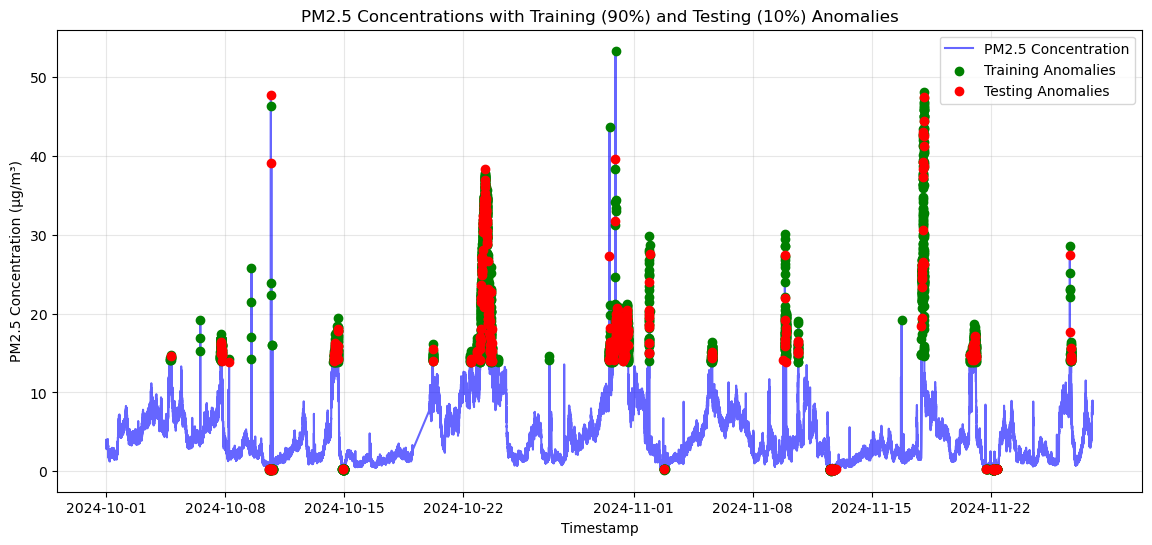

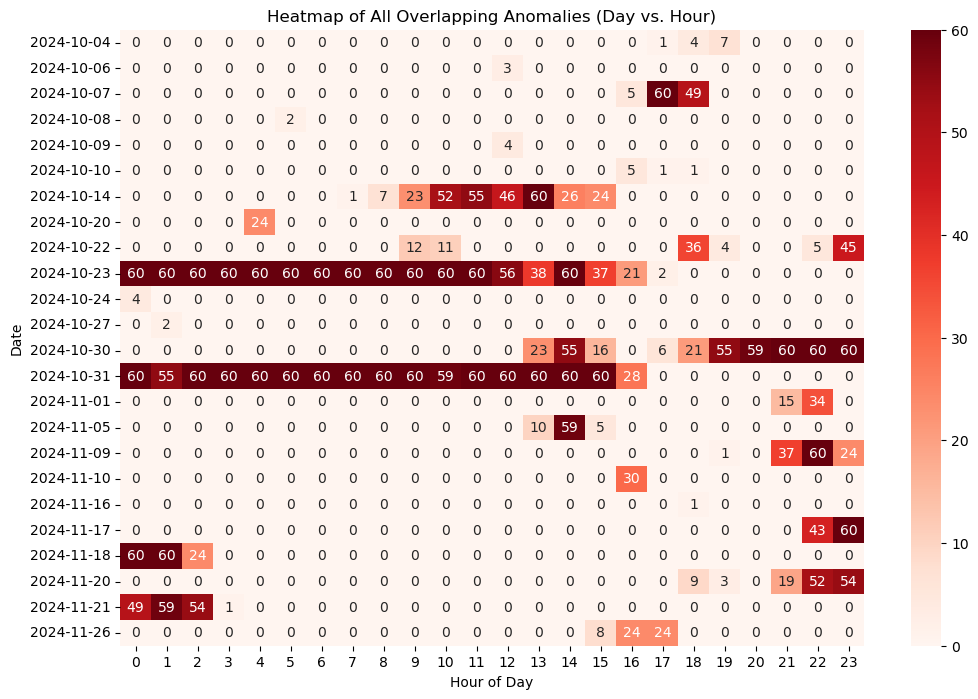

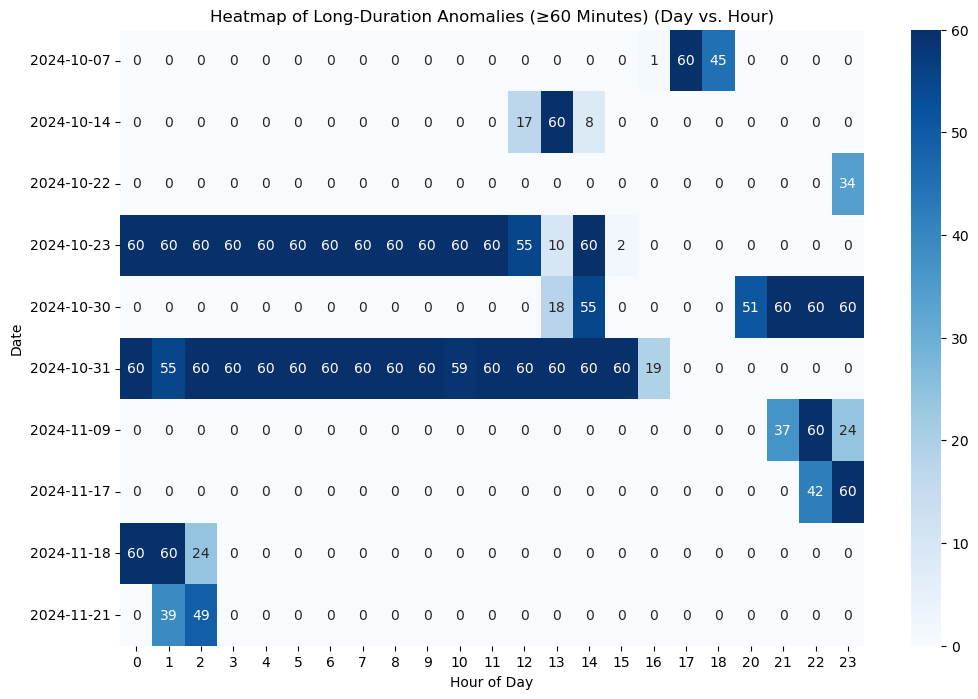

In [26]:
import pandas as pd  # For data manipulation and analysis
import matplotlib.pyplot as plt  # For creating visualizations
from sklearn.ensemble import IsolationForest  # For anomaly detection using Isolation Forest
from sklearn.metrics import classification_report  # For model evaluation
from sklearn.model_selection import train_test_split  # For splitting data into training and testing
import seaborn as sns  # For creating heatmaps and advanced visualizations

# Load the dataset
file_path = 'MOD-00068-146f1681c6f342799117874b40bbb3d3.csv'  # Path to your dataset
data = pd.read_csv(file_path)  # Read the CSV file into a Pandas DataFrame

# Convert the 'timestamp' column to datetime format for proper time-based operations
data['timestamp'] = pd.to_datetime(data['timestamp'])

# Filter the data to include only records from October 1 onward
data = data[data['timestamp'] >= '2024-10-01']

# Remove all records for October 19, as they are excluded from the analysis
data = data[~(data['timestamp'].dt.date == pd.Timestamp('2024-10-19').date())]

# Focus on PM2.5 concentration data and drop rows with missing values
pm25_data = data[['timestamp', 'pm25']].dropna()

### IQR-Based Anomaly Detection ##############################################
def detect_anomalies_iqr(column):
    """
    Detect anomalies using the Interquartile Range (IQR) method.
    Parameters:
    - column: A Pandas Series containing the data to analyze.
    Returns:
    - lower_bound: Lower threshold for anomalies.
    - upper_bound: Upper threshold for anomalies.
    """
    Q1 = column.quantile(0.25)  # Calculate the 25th percentile (Q1)
    Q3 = column.quantile(0.75)  # Calculate the 75th percentile (Q3)
    IQR = Q3 - Q1  # Compute the Interquartile Range (IQR)
    lower_bound = Q1 - 1.5 * IQR  # Define the lower threshold for anomalies
    upper_bound = Q3 + 1.5 * IQR  # Define the upper threshold for anomalies
    return lower_bound, upper_bound

# Calculate thresholds for anomalies using IQR
pm25_lower, pm25_upper = detect_anomalies_iqr(pm25_data['pm25'])

# Mark anomalies based on IQR thresholds
pm25_data['iqr_anomaly'] = (pm25_data['pm25'] < pm25_lower) | (pm25_data['pm25'] > pm25_upper)

### Train-Test Split ###
# Split 90% of the data for training and 10% for testing
train_data, test_data = train_test_split(pm25_data, test_size=0.1, random_state=42)

### Isolation Forest Anomaly Detection ############################################
# Initialize and train an Isolation Forest model with 5% contamination
isolation_forest = IsolationForest(contamination=0.05, random_state=42)
train_data['if_anomaly_score'] = isolation_forest.fit_predict(train_data[['pm25']])  # Train on 90% of the data

# Predict anomalies on the testing set
test_data['if_anomaly_score'] = isolation_forest.predict(test_data[['pm25']])  # Test on the remaining 10%

# Mark anomalies (score = -1) in both datasets
train_data['if_anomaly'] = train_data['if_anomaly_score'] == -1
test_data['if_anomaly'] = test_data['if_anomaly_score'] == -1

# Combine train and test results back into the main dataset
train_data['set'] = 'train'
test_data['set'] = 'test'
pm25_data = pd.concat([train_data, test_data]).sort_index()

### Evaluation of Model Performance ###
# Generate ground truth for testing based on IQR upper bound
test_data['true_label'] = test_data['pm25'] > pm25_upper

# Classification Report
print("Classification Report (Testing Set):")
print(classification_report(test_data['true_label'], test_data['if_anomaly']))

### Visualization of Training and Testing Anomalies ###
plt.figure(figsize=(14, 6))
plt.plot(pm25_data['timestamp'], pm25_data['pm25'], label='PM2.5 Concentration', color='blue', alpha=0.6)
plt.scatter(
    train_data.loc[train_data['if_anomaly'], 'timestamp'],  # Anomalies in training data
    train_data.loc[train_data['if_anomaly'], 'pm25'],
    color='green', label='Training Anomalies', zorder=5
)
plt.scatter(
    test_data.loc[test_data['if_anomaly'], 'timestamp'],  # Anomalies in testing data
    test_data.loc[test_data['if_anomaly'], 'pm25'],
    color='red', label='Testing Anomalies', zorder=5
)
plt.title('PM2.5 Concentrations with Training (90%) and Testing (10%) Anomalies')
plt.xlabel('Timestamp')
plt.ylabel('PM2.5 Concentration (µg/m³)')
plt.legend()
plt.grid(alpha=0.3)
plt.savefig('random_split_anomalies.png')  # Save the visualization
plt.show()

### Heatmap of All Overlapping Anomalies #############################################
# Extract hour and day for heatmap visualization
pm25_data['hour'] = pm25_data['timestamp'].dt.hour  # Extract hour
pm25_data['day'] = pm25_data['timestamp'].dt.date  # Extract date

# Create a pivot table for all overlapping anomalies
heatmap_data_all = pm25_data[pm25_data['iqr_anomaly']].pivot_table(
    index='day',  # Rows represent dates
    columns='hour',  # Columns represent hours
    values='pm25',  # Count anomalies
    aggfunc='count',
    fill_value=0  # Replace NaN with 0
)

# Plot the heatmap for all overlapping anomalies
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data_all, cmap='Reds', annot=True, fmt='d', cbar=True)  # Create the heatmap
plt.title('Heatmap of All Overlapping Anomalies (Day vs. Hour)')
plt.xlabel('Hour of Day')
plt.ylabel('Date')
plt.savefig('heatmap_all_overlapping_anomalies.png')  # Save the heatmap
plt.show()

### Heatmap of Long-Duration Anomalies (≥60 Minutes) ###
# Group anomalies into events and calculate duration
pm25_data['event_group'] = (pm25_data['iqr_anomaly'] != pm25_data['iqr_anomaly'].shift()).cumsum()
anomaly_durations = pm25_data[pm25_data['iqr_anomaly']].groupby('event_group').agg(
    start_time=('timestamp', 'min'),  # Start time of the event
    end_time=('timestamp', 'max'),    # End time of the event
    duration=('timestamp', lambda x: (x.max() - x.min()).seconds / 60)  # Duration in minutes
).reset_index()

# Filter out anomalies with durations less than 60 minutes
long_duration_anomalies = anomaly_durations[anomaly_durations['duration'] >= 60]

# Retain only long-duration anomalies in the main dataset
valid_event_groups = long_duration_anomalies['event_group'].unique()
pm25_data['long_duration_overlap'] = pm25_data['event_group'].isin(valid_event_groups)

# Create a pivot table for long-duration anomalies
heatmap_data_long = pm25_data[pm25_data['long_duration_overlap']].pivot_table(
    index='day',  # Rows represent dates
    columns='hour',  # Columns represent hours
    values='pm25',  # Count anomalies
    aggfunc='count',
    fill_value=0  # Replace NaN with 0
)

# Plot the heatmap for long-duration anomalies
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data_long, cmap='Blues', annot=True, fmt='d', cbar=True)  # Create the heatmap
plt.title('Heatmap of Long-Duration Anomalies (≥60 Minutes) (Day vs. Hour)')
plt.xlabel('Hour of Day')
plt.ylabel('Date')
plt.savefig('heatmap_long_duration_anomalies.png')  # Save the heatmap
plt.show()

### Save Training and Testing Datasets ###
train_data.to_csv('pm25_train_data.csv', index=False)  # Save training data
test_data.to_csv('pm25_test_data.csv', index=False)  # Save testing data
